开始实验 4: CNN 上的全批次 GD 训练...
Step 10000/100000, Loss: 0.778500, Trajectory Error: 6.91e-15
Step 20000/100000, Loss: 0.735545, Trajectory Error: 9.52e-15
Step 30000/100000, Loss: 0.711766, Trajectory Error: 1.55e-14
Step 40000/100000, Loss: 0.699219, Trajectory Error: 2.22e-14
Step 50000/100000, Loss: 0.696324, Trajectory Error: 4.38e-14
Step 60000/100000, Loss: 0.695633, Trajectory Error: 2.11e-13
Step 70000/100000, Loss: 0.695269, Trajectory Error: 1.21e-12
Step 80000/100000, Loss: 0.695152, Trajectory Error: 6.98e-12
Step 90000/100000, Loss: 0.695130, Trajectory Error: 4.06e-11
Step 100000/100000, Loss: 0.695126, Trajectory Error: 2.36e-10

--- 训练结束，结果汇总 ---
最大轨迹误差 (Max Trajectory Error): 2.3636e-10
小网络最终参数范数 (Final Weight Norm of Small Net): 2.7286
大网络最终参数范数 (Final Weight Norm of Large Net): 2.7286
---------------------------

开始绘制实验结果图...


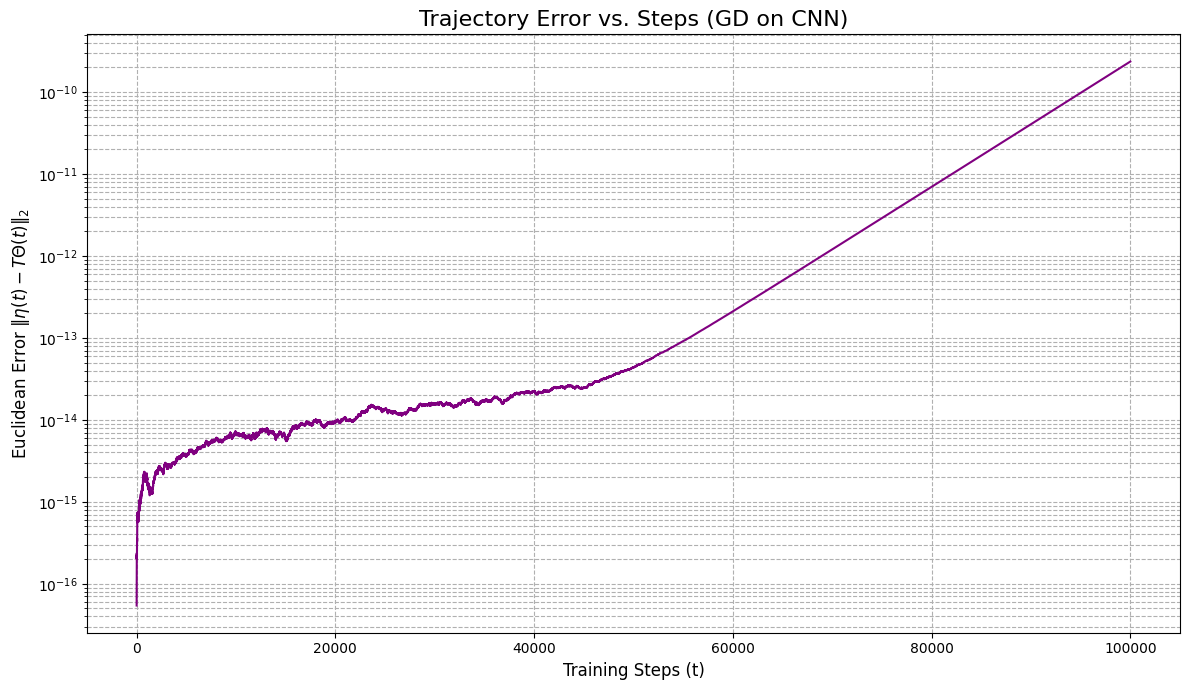

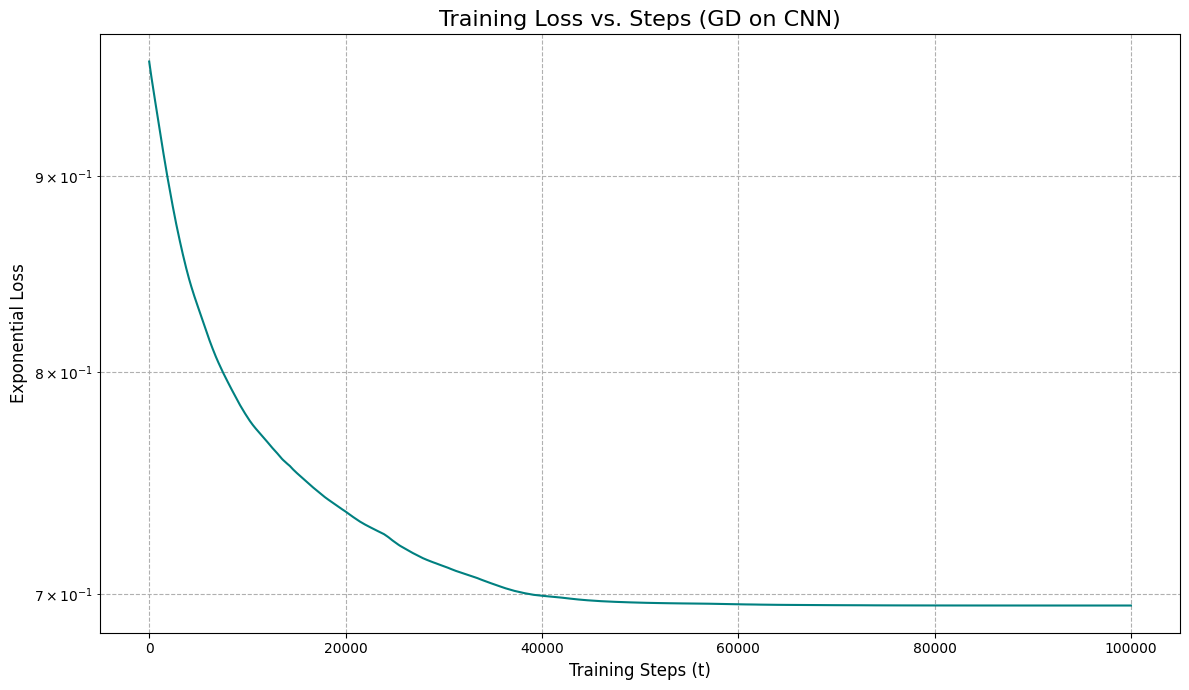


实验4的2张图已生成并保存为PDF。


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# --- 1. Experiment Setup ---
# Core modification: Lower learning rate for stability
LEARNING_RATE = 0.001 # CNNs can be sensitive to learning rate
N_STEPS = 100000       # Fewer steps needed for this simpler task

N_SAMPLES = 200
IMAGE_SIZE = 5        # Input data will be reshaped to 5x5
INPUT_CHANNELS = 1    # Grayscale image

# Small CNN architecture
SMALL_CNN_OUT_CHANNELS = 2
# Large CNN architecture (splitting the 2 channels into 4)
LARGE_CNN_OUT_CHANNELS = 4 
SPLIT_FACTOR = LARGE_CNN_OUT_CHANNELS // SMALL_CNN_OUT_CHANNELS

KERNEL_SIZE = 3
OUTPUT_DIM = 1

torch.manual_seed(42)
np.random.seed(42)

# --- 2. Data Generation ---
def generate_cnn_data(n_samples=200, image_size=5):
    """
    Generates a simple binary classification dataset suitable for a CNN.
    """
    dtype = torch.double
    X_np, y_np = make_classification(
        n_samples=n_samples, 
        n_features=image_size*image_size, 
        n_informative=5, 
        n_redundant=0, 
        n_clusters_per_class=2,
        flip_y=0,
        random_state=42
    )
    
    # Reshape X to be image-like: (N, C, H, W)
    X = torch.tensor(X_np, dtype=dtype).view(n_samples, 1, image_size, image_size)
    # Reshape y to be (N, 1) and labels to be {-1, 1}
    y = torch.tensor(y_np, dtype=dtype).view(-1, 1) * 2 - 1
    
    return X, y

# --- 3. Model Definition ---
def leaky_relu(x, negative_slope=0.01):
    return torch.where(x > 0, x, x * negative_slope)

# Small Homogeneous CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer -> Flatten -> Linear layer
        self.conv1 = nn.Conv2d(INPUT_CHANNELS, SMALL_CNN_OUT_CHANNELS, KERNEL_SIZE, bias=False)
        
        # Calculate flattened size
        conv_output_size = IMAGE_SIZE - KERNEL_SIZE + 1
        flattened_size = SMALL_CNN_OUT_CHANNELS * conv_output_size * conv_output_size
        
        self.fc1 = nn.Linear(flattened_size, OUTPUT_DIM, bias=False)
        self.to(torch.double)

    def forward(self, x):
        x = leaky_relu(self.conv1(x))
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc1(x)
        return x

# Large Homogeneous CNN
class LargeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(INPUT_CHANNELS, LARGE_CNN_OUT_CHANNELS, KERNEL_SIZE, bias=False)
        
        conv_output_size = IMAGE_SIZE - KERNEL_SIZE + 1
        flattened_size = LARGE_CNN_OUT_CHANNELS * conv_output_size * conv_output_size
        
        self.fc1 = nn.Linear(flattened_size, OUTPUT_DIM, bias=False)
        self.to(torch.double)

    def forward(self, x):
        x = leaky_relu(self.conv1(x))
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc1(x)
        return x

# --- 4. Channel Splitting Transformation T for CNN ---
def transform_cnn_params(params_small):
    """
    Applies channel splitting transformation to the CNN parameters.
    """
    W_conv_small = params_small['conv1.weight']
    W_fc_small = params_small['fc1.weight']

    # Splitting coefficients (c_i)
    coeffs = torch.tensor([1.0 / np.sqrt(SPLIT_FACTOR)] * SPLIT_FACTOR, dtype=torch.double)

    # 1. Split the output channels of the convolutional layer
    w_conv_split_list = []
    for i in range(SMALL_CNN_OUT_CHANNELS):
        original_filter = W_conv_small[i:i+1] # Shape: (1, C_in, K, K)
        for j in range(SPLIT_FACTOR):
            w_conv_split_list.append(coeffs[j] * original_filter)
    W_conv_large = torch.cat(w_conv_split_list, dim=0)

    # 2. Split the input features of the fully-connected layer
    w_fc_split_list = []
    group_size = (IMAGE_SIZE - KERNEL_SIZE + 1)**2
    for i in range(SMALL_CNN_OUT_CHANNELS):
        original_weight_group = W_fc_small[:, i*group_size:(i+1)*group_size]
        for j in range(SPLIT_FACTOR):
            w_fc_split_list.append(coeffs[j] * original_weight_group)
    W_fc_large = torch.cat(w_fc_split_list, dim=1)
    
    return {'conv1.weight': W_conv_large, 'fc1.weight': W_fc_large}


# --- 5. Loss Function ---
def exponential_loss(y_pred, y_true):
    return torch.mean(torch.exp(-y_true * y_pred))

# --- 6. Main Training Loop ---
if __name__ == '__main__':
    X, y = generate_cnn_data(image_size=IMAGE_SIZE)
    
    small_net = SmallCNN()
    large_net = LargeCNN()

    nn.init.kaiming_normal_(small_net.conv1.weight, a=math.sqrt(5))
    nn.init.kaiming_normal_(small_net.fc1.weight, a=math.sqrt(5))
    
    with torch.no_grad():
        initial_large_params = transform_cnn_params(dict(small_net.named_parameters()))
        large_net.conv1.weight.data = initial_large_params['conv1.weight']
        large_net.fc1.weight.data = initial_large_params['fc1.weight']

    optimizer_small = torch.optim.SGD(small_net.parameters(), lr=LEARNING_RATE)
    optimizer_large = torch.optim.SGD(large_net.parameters(), lr=LEARNING_RATE)

    error_history = []
    loss_history = []
    
    print("Starting Experiment 4: Full-batch GD on CNN...")
    for step in range(N_STEPS):
        optimizer_small.zero_grad()
        output_small = small_net(X)
        loss_small = exponential_loss(output_small, y)
        loss_small.backward()
        optimizer_small.step()
        
        optimizer_large.zero_grad()
        output_large = large_net(X)
        loss_large = exponential_loss(output_large, y)
        loss_large.backward()
        optimizer_large.step()
        
        with torch.no_grad():
            predicted_params_large = transform_cnn_params(dict(small_net.named_parameters()))
            
            # Core modification: Explicitly order parameters to avoid potential dictionary order issues
            actual_vec = torch.cat([
                large_net.conv1.weight.flatten(),
                large_net.fc1.weight.flatten()
            ])
            predicted_vec = torch.cat([
                predicted_params_large['conv1.weight'].flatten(),
                predicted_params_large['fc1.weight'].flatten()
            ])
            
            error = torch.norm(actual_vec - predicted_vec).item()
            error_history.append(error)
            loss_history.append(loss_small.item())

        if (step + 1) % (N_STEPS // 10) == 0:
            print(f"Step {step+1}/{N_STEPS}, Loss: {loss_small.item():.6f}, Trajectory Error: {error:.2e}")

    # --- 7. Final Results Summary ---
    print("\n--- Training finished, summarizing results ---")
    max_trajectory_error = max(error_history)
    print(f"Max Trajectory Error: {max_trajectory_error:.4e}")
    
    with torch.no_grad():
        norm_small = torch.norm(torch.cat([p.flatten() for p in small_net.parameters()]))
        norm_large = torch.norm(torch.cat([p.flatten() for p in large_net.parameters()]))
    print(f"Final Weight Norm of Small Net: {norm_small:.4f}")
    print(f"Final Weight Norm of Large Net: {norm_large:.4f}")
    print("---------------------------\n")

    # --- 8. Plotting Results ---
    print("Plotting experiment results...")

    # Figure 1: Trajectory Error vs. Training Steps
    plt.figure(figsize=(12, 7))
    plt.plot(error_history, color='purple')
    plt.title('Trajectory Error vs. Steps (GD on CNN)', fontsize=16)
    plt.xlabel('Training Steps (t)', fontsize=12)
    plt.ylabel('Euclidean Error $\|\eta(t) - T\Theta(t)\|_2$', fontsize=12)
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig("exp4_cnn_gd_error.pdf")
    plt.show()

    # Figure 2: Training Loss vs. Training Steps
    plt.figure(figsize=(12, 7))
    plt.plot(loss_history, color='teal')
    plt.title('Training Loss vs. Steps (GD on CNN)', fontsize=16)
    plt.xlabel('Training Steps (t)', fontsize=12)
    plt.ylabel('Exponential Loss', fontsize=12)
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig("exp4_cnn_gd_loss.pdf")
    plt.show()
    
    print("\nAll 2 figures for Experiment 4 have been generated and saved as PDF.")